# Look at kitti data and see if I can convert to azimuth, height, distance format

## Look at kitti in point cloud binary format

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import json
import os

In [8]:
# Load point cloud data
bin_path = '../data/2011_09_26_drive_0017_sync/velodyne_points/data/0000000100.bin'
points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

In [9]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.'''
    
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the 'box size'.
    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

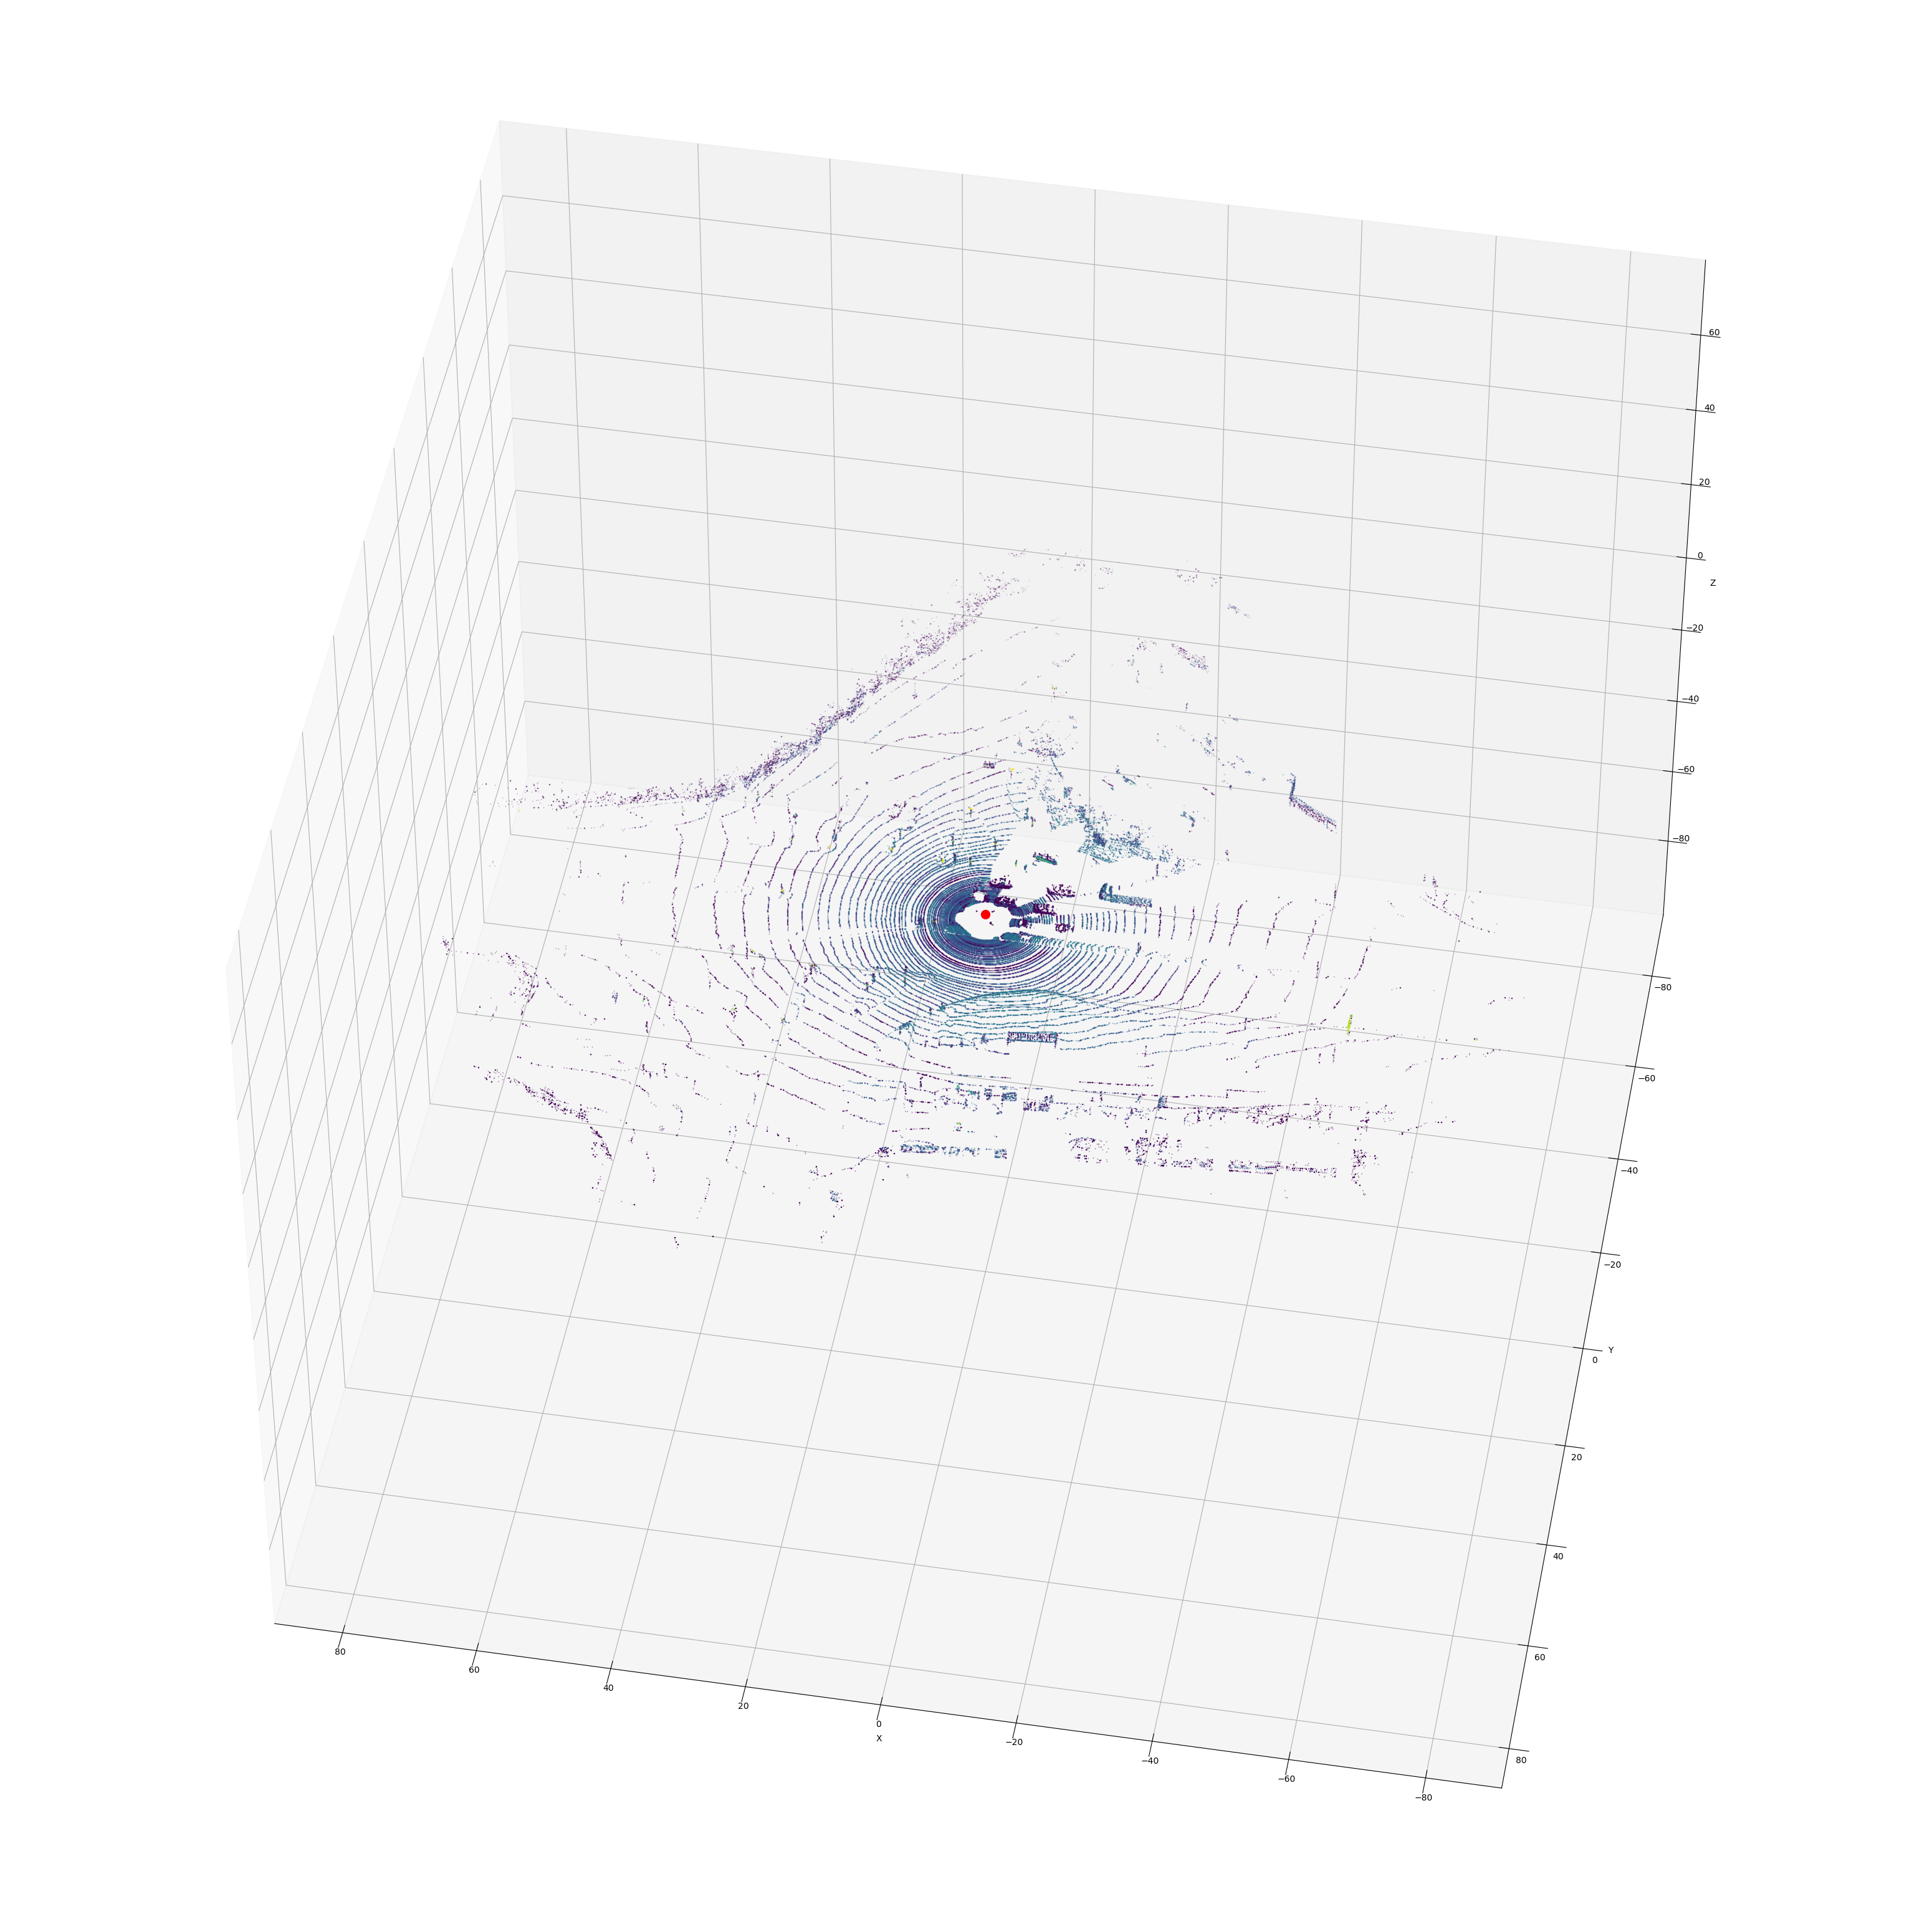

In [10]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, c=points[:, 3], cmap='viridis', marker=',')
ax.scatter(0, 0, 0, s=100, c='red', marker='o')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=45, azim=100) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()
plt.savefig('test.png')

## Convert to azimuth, height, distance format

In [11]:
def convert_points_to_polar(bin_file_path):
    # Load point cloud data from .bin file
    num_points = 4  # x, y, z, intensity
    data = np.fromfile(bin_file_path, dtype=np.float32)
    points = data.reshape(-1, num_points)

    # Calculate azimuth in degrees
    azimuth = np.degrees(np.arctan2(points[:, 1], points[:, 0]))

    # Calculate elevation in degrees
    elevation = np.degrees(np.arctan2(points[:, 2], np.sqrt(points[:, 0]**2 + points[:, 1]**2)))

    # Calculate distance
    distance = np.sqrt(np.sum(points[:, :3]**2, axis=1))

    # Create a DataFrame
    df = pd.DataFrame({
        'Azimuth': azimuth,
        'Elevation': elevation,
        'Distance': distance,
        'Intensity': points[:, 3]
    })

    return df

## What is the distance measured in?

In [12]:
# Usage
polar_df = convert_points_to_polar(bin_path)
print(polar_df.head())

    Azimuth  Elevation   Distance  Intensity
0  0.098019   2.302210  32.760494       0.23
1  0.277548   2.301179  32.849876       0.00
2  0.458117   2.305173  32.544376       0.00
3  0.929024   2.136147  60.175720       0.00
4  1.109021   2.135864  60.130028       0.00


In [13]:
polar_df.describe()

,Azimuth,Elevation,Distance,Intensity
count,116644.000000,116644.000000,116644.000000,116644.000000
mean,4.337594,-9.234881,17.614801,0.215773
std,99.593727,7.052813,16.037220,0.143751
min,-180.000000,-24.227907,1.462862,0.000000
25%,-79.840439,-15.118146,6.063750,0.110000
50%,7.506324,-8.366051,10.986212,0.250000
75%,90.657705,-3.437263,23.127408,0.310000
max,180.000000,3.550540,80.004280,0.990000


In [14]:
# Next steps
# Superimpose all frames into one frame
# Take farthest points

# Divide the vectors into a sort of grid.
# any point can be mapped to it's grid location by "rounding down" to the nearest indicating coordinates

# So make a background map out of all of these points.
# I make a dataframe with each bottom left corner of the grid.
# The I go through each binary file, and for each point, I map it to the grid (by rounding down)
# Each grid square will have a list of distances. I can get the median of the distance for each grid, and the max
# I'll take the median map and the max map and change them back into x,y,z coordinates (maybe take the average of the intensities?)
# And display the map to see what it looks like

# For each point that I'm checking against the background map, I can "round up" to the "top corner" of the square cone.

# Try to make a background map

## Create a "grid" for points
And a dataframe for that grid

In [46]:
# Create the grid DataFrames
def create_grid_dataframes(azimuth_map, height_map):
    grid_shape = (len(height_map), len(azimuth_map))
    df_distances = pd.DataFrame({key: [[] for _ in range(len(height_map))] for key in azimuth_map.keys()}, index=height_map.keys())
    df_intensities = pd.DataFrame({key: [[] for _ in range(len(height_map))] for key in azimuth_map.keys()}, index=height_map.keys())
    return df_distances, df_intensities

In [47]:
# Create mappings for azimuth and height using integers
def create_mappings(azimuth_step=0.5, height_step=0.1):
    azimuth_range = np.arange(-180, 180.5, azimuth_step)
    height_range = np.arange(-30, 10.1, height_step)
    azimuth_map = {int(az * 10): idx for idx, az in enumerate(azimuth_range)}
    height_map = {int(ht * 10): idx for idx, ht in enumerate(height_range)}
    return azimuth_map, height_map

## Populate the grid
By going through each frame and mapping each point to the grid

In [48]:
# Process file into grid
def process_file_to_grid(file_path, df_distances, df_intensities, azimuth_map, height_map):
    data = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    for x, y, z, intensity in data:
        distance = np.sqrt(x**2 + y**2 + z**2)
        azimuth = np.degrees(np.arctan2(y, x))
        height = np.degrees(np.arctan2(z, np.sqrt(x**2 + y**2)))
        # Convert and scale
        azimuth_idx = int(np.floor((azimuth + 180) / 0.5) * 0.5 * 10) - 1800
        height_idx = int(np.floor((height + 30) / 0.1) * 0.1 * 10) - 300
        # Update DataFrames directly using indices
        if azimuth_idx in azimuth_map and height_idx in height_map:
            df_distances.at[height_idx, azimuth_idx].append(distance)
            df_intensities.at[height_idx, azimuth_idx].append(intensity)

In [49]:
# Function to process a single file into a DataFrame
def process_file_to_df(file_path):
    print('processing file, converting to polar, and rounding')
    data = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    df = pd.DataFrame(data, columns=['x', 'y', 'z', 'intensity'])
    df['distance'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    df['azimuth'] = np.degrees(np.arctan2(df['y'], df['x']))
    df['height'] = np.degrees(np.arctan2(df['z'], np.sqrt(df['x']**2 + df['y']**2)))
    df['azimuth'] = np.floor((df['azimuth'] + 180) / 0.5) * 0.5 - 180
    df['height'] = np.floor((df['height'] + 30) / 0.1) * 0.1 - 30
    return df

In [50]:
# Function to update the grid DataFrame using the data DataFrame
def update_grid(df_grid, df_data):
    print('updating background map grid')
    # Group by azimuth and height and aggregate lists
    grouped = df_data.groupby(['azimuth', 'height']).agg(list).reset_index()
    for index, row in grouped.iterrows():
        mask = (df_grid['Azimuth'] == row['azimuth']) & (df_grid['Height'] == row['height'])
        if not df_grid.loc[mask, 'Distances'].empty:
            df_grid.loc[mask, 'Distances'].iloc[0].extend(row['distance'])
            df_grid.loc[mask, 'Intensities'].iloc[0].extend(row['intensity'])

In [51]:
# Main function
def process_all_files(directory_path):
    azimuth_map, height_map = create_mappings()
    df_distances, df_intensities = create_grid_dataframes(azimuth_map, height_map)
    files = [f for f in os.listdir(directory_path) if f.endswith('.bin')]
    for filename in files[:30]:  # Process only the first 10 files
        print('processing file: ' + filename)
        file_path = os.path.join(directory_path, filename)
        process_file_to_grid(file_path, df_distances, df_intensities, azimuth_map, height_map)
    return df_distances, df_intensities

In [52]:
directory_path = '../data/2011_09_26_drive_0017_sync/velodyne_points/data'
df_distances, df_intensities = process_all_files(directory_path)
# print(df_distances)
# print(df_intensities)

processing file: 0000000071.bin
processing file: 0000000004.bin
processing file: 0000000011.bin
processing file: 0000000091.bin
processing file: 0000000031.bin
processing file: 0000000003.bin
processing file: 0000000014.bin
processing file: 0000000081.bin
processing file: 0000000048.bin
processing file: 0000000111.bin
processing file: 0000000112.bin
processing file: 0000000083.bin
processing file: 0000000096.bin
processing file: 0000000074.bin
processing file: 0000000089.bin
processing file: 0000000047.bin
processing file: 0000000025.bin
processing file: 0000000030.bin
processing file: 0000000072.bin
processing file: 0000000052.bin
processing file: 0000000098.bin
processing file: 0000000055.bin
processing file: 0000000038.bin
processing file: 0000000046.bin
processing file: 0000000109.bin
processing file: 0000000037.bin
processing file: 0000000065.bin
processing file: 0000000049.bin
processing file: 0000000110.bin
processing file: 0000000069.bin


In [53]:
df_distances.describe()

,-1800,-1795,-1790,-1785,-1780,-1775,-1770,-1765,-1760,-1755,...,1755,1760,1765,1770,1775,1780,1785,1790,1795,1800
count,400,400,400,400,400,400,400,400,400,400,...,400,400,400,400,400,400,400,400,400,400
unique,128,134,132,133,125,125,120,110,103,98,...,118,122,136,134,140,134,133,137,130,13
top,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
freq,273,267,269,268,276,276,281,291,298,303,...,283,279,265,267,261,267,268,264,271,388


## Use the grid point lists to make background maps

In [54]:
# Function to create the background map DataFrame
def create_background_map(df_distances, df_intensities):
    # Initialize a list to store each row (as a dictionary) before creating the DataFrame
    data = []

    # Iterate through each cell in df_distances
    for (height, azimuth), distances in df_distances.stack().items():
        if distances:  # Make sure there are distances recorded in the cell
            # Get the corresponding intensities
            intensities = df_intensities.at[height, azimuth]
            
            # Calculate the median distance and average intensity
            distance = np.max(distances) + np.std(distances)
            average_intensity = np.mean(intensities)

            # Prepare a dictionary for the new row
            new_row = {
                'Azimuth': azimuth / 10,  # Convert back to original scale
                'Height': height / 10,    # Convert back to original scale
                'Distance': distance,
                'Average Intensity': average_intensity
            }
            data.append(new_row)

    # Create the DataFrame from the list of dictionaries
    background_map = pd.DataFrame(data)
    return background_map

In [55]:
background_map_df = create_background_map(df_distances, df_intensities)
print(background_map_df.head())

   Azimuth  Height  Distance  Average Intensity
0     18.0   -24.3  7.802703           0.031228
1     18.5   -24.3  7.796880           0.000000
2     18.0   -23.8  7.753788           0.000000
3   -150.5   -23.7  4.568514           0.000000
4   -150.0   -23.7  4.560942           0.000000


In [56]:
background_map_df.describe()

,Azimuth,Height,Distance,Average Intensity
count,62436.000000,62436.000000,62436.000000,62436.000000
mean,-15.306874,-8.738585,18.150128,0.201271
std,107.398620,6.960106,16.502916,0.142061
min,-180.000000,-24.300000,1.460014,0.000000
25%,-114.500000,-14.300000,6.328451,0.070000
50%,-24.500000,-7.300000,12.631899,0.222941
75%,79.000000,-3.000000,23.296888,0.301598
max,180.000000,3.500000,111.423818,0.990000


In [57]:
csv_filename = 'background_map.cvs'
background_map_df.to_csv(csv_filename, index=False)

## Display background maps

In [58]:
def get_xyz_format(df):
    df_copy = df.copy()

    # Convert degrees to radians
    df_copy['Azimuth'] = np.radians(df_copy['Azimuth'])
    df_copy['Height'] = np.radians(df_copy['Height'])

    # Convert spherical to Cartesian coordinates
    df_copy['x'] = df_copy['Distance'] * np.cos(df_copy['Height']) * np.cos(df_copy['Azimuth'])
    df_copy['y'] = df_copy['Distance'] * np.cos(df_copy['Height']) * np.sin(df_copy['Azimuth'])
    df_copy['z'] = df_copy['Distance'] * np.sin(df_copy['Height'])

    # Create a new DataFrame with the required format
    cartesian_format = pd.DataFrame({
        'x': df_copy['x'],
        'y': df_copy['y'],
        'z': df_copy['z'],
        'Intensity': df_copy['Average Intensity']
    })
    
    return cartesian_format

In [59]:
new_cartesian_format = get_xyz_format(background_map_df)
print(new_cartesian_format)

              x         y         z  Intensity
0      6.763352  2.197546 -3.210924   0.031228
1      6.738884  2.254799 -3.208528   0.000000
2      6.747178  2.192291 -3.129005   0.000000
3     -3.640887 -2.059915 -1.836304   0.000000
4     -3.616768 -2.088142 -1.833261   0.000000
...         ...       ...       ...        ...
62431  9.097374  2.694765  0.530467   0.395806
62432  9.097764  2.781466  0.531885   0.048421
62433  7.206887  2.481530  0.466191   0.141042
62434  7.239595  2.563675  0.469736   0.359390
62435  7.160924  2.606363  0.466089   0.000000

[62436 rows x 4 columns]


In [60]:
new_cartesian_format.describe()

,x,y,z,Intensity
count,62436.000000,62436.000000,62436.000000,62436.000000
mean,-1.031032,-1.117489,-1.300869,0.201271
std,17.324226,17.230800,0.863293,0.142061
min,-97.145253,-106.621580,-27.469828,0.000000
25%,-7.685558,-7.227414,-1.751736,0.070000
50%,-1.435796,-2.068836,-1.625886,0.222941
75%,6.256121,5.356779,-1.046668,0.301598
max,110.585028,86.271515,3.608489,0.990000


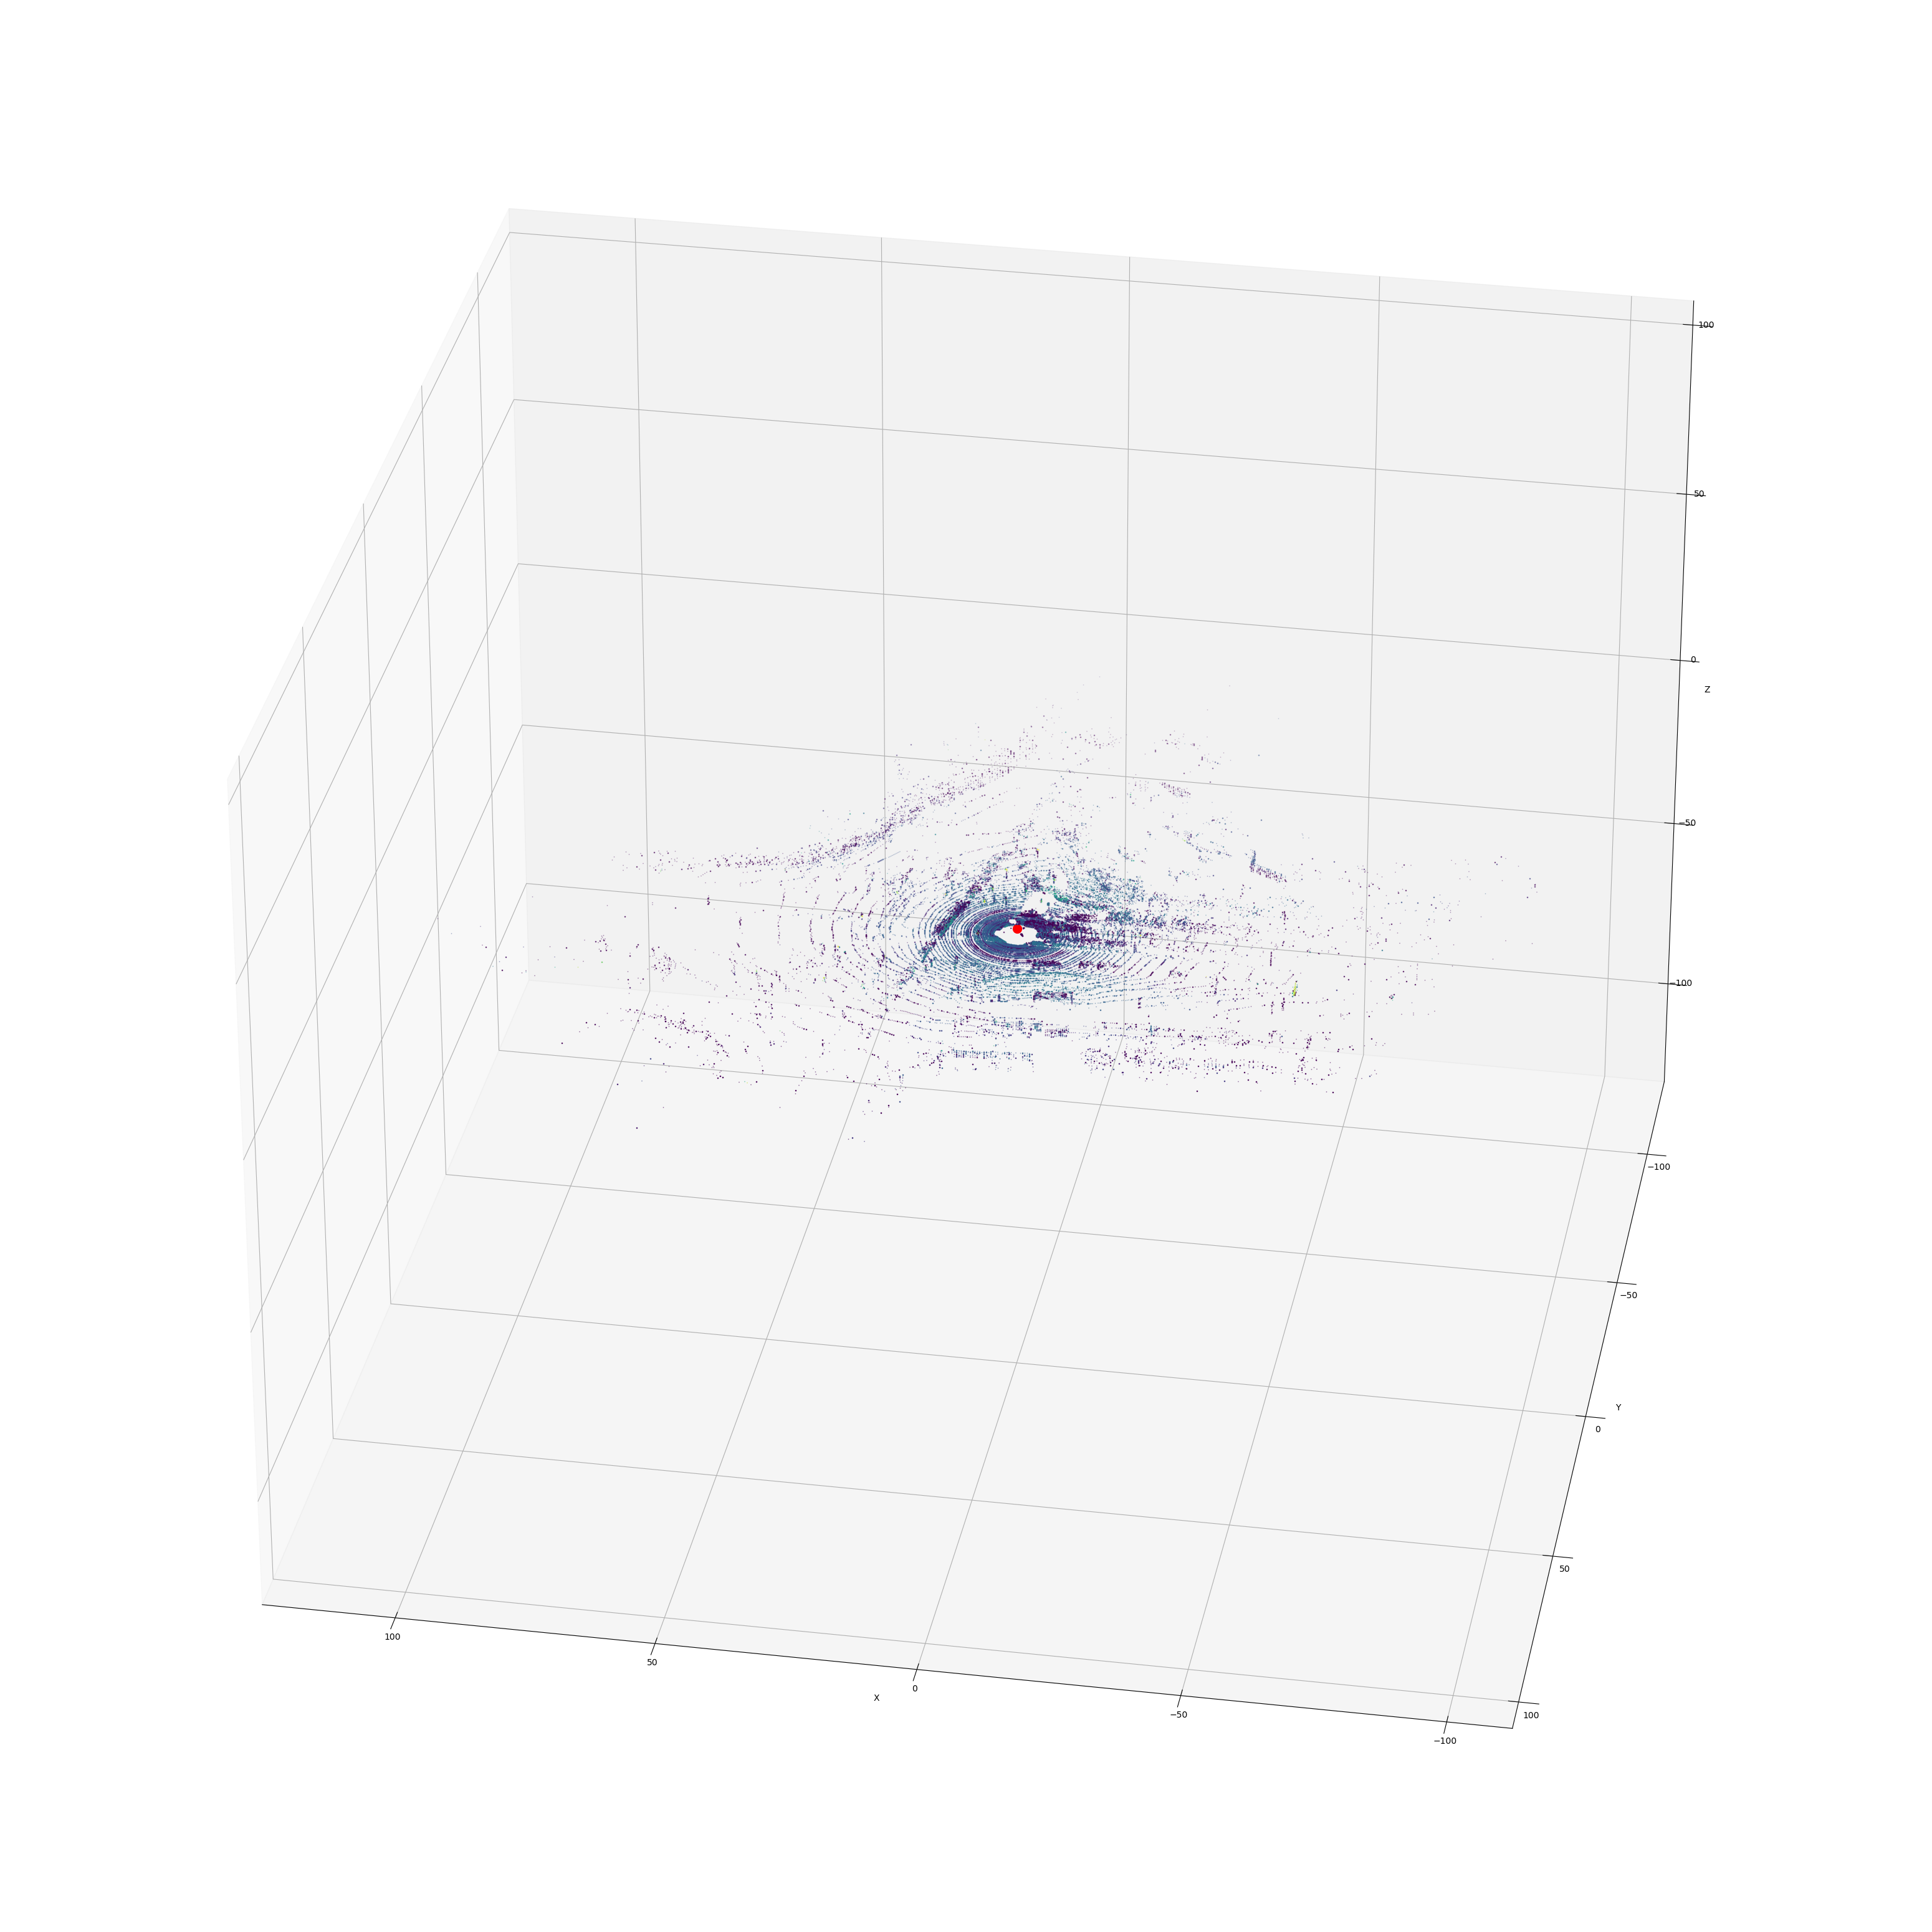

In [61]:
# from mpl_toolkits.mplot3d import Axes3D

# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud using DataFrame column names
ax.scatter(
    new_cartesian_format['x'], 
    new_cartesian_format['y'], 
    new_cartesian_format['z'], 
    s=0.1, 
    c=new_cartesian_format['Intensity'], 
    cmap='viridis', 
    marker=','
)

ax.scatter(0, 0, 0, s=100, c='red', marker='o')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=30, azim=100)

set_axes_equal(ax)  # Ensure the aspect ratio is equal

plt.show()

In [62]:
from ipywidgets import interact, widgets

# Function to update the plot based on the azimuth and elevation
def update_plot(azim, elev):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(
        new_cartesian_format['x'],
        new_cartesian_format['y'],
        new_cartesian_format['z'],
        c=new_cartesian_format['Intensity'],
        s=0.01,
        cmap='viridis',
        marker=','
    )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=elev, azim=azim)
    set_axes_equal(ax)  # Ensure the aspect ratio is equal
    plt.show()

# Create sliders for azimuth and elevation
azim_slider = widgets.IntSlider(min=-180, max=180, step=1, value=0, description='Azimuth')
elev_slider = widgets.IntSlider(min=-90, max=90, step=1, value=30, description='Elevation')
zoom_slider = widgets.FloatSlider(min=0.1, max=3.0, step=0.1, value=1.0, description='Zoom')

# Display the interactive plot
interact(update_plot, azim=azim_slider, elev=elev_slider)

interactive(children=(IntSlider(value=0, description='Azimuth', max=180, min=-180), IntSlider(value=30, descri…

<function __main__.update_plot(azim, elev)>

## Try filtering

In [63]:
# Filter frame
# Load point cloud data
bin_path = '../data/2011_09_26_drive_0017_sync/velodyne_points/data/0000000030.bin'
pre_filtered_points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

In [30]:
# get polar format
pre_filtered_polar = convert_points_to_polar(pre_filtered_points)
# convert to grid lookup format
# get the grid

# if the grid distance is greater than the point's distance
# then add it to the new, filtered dataframe

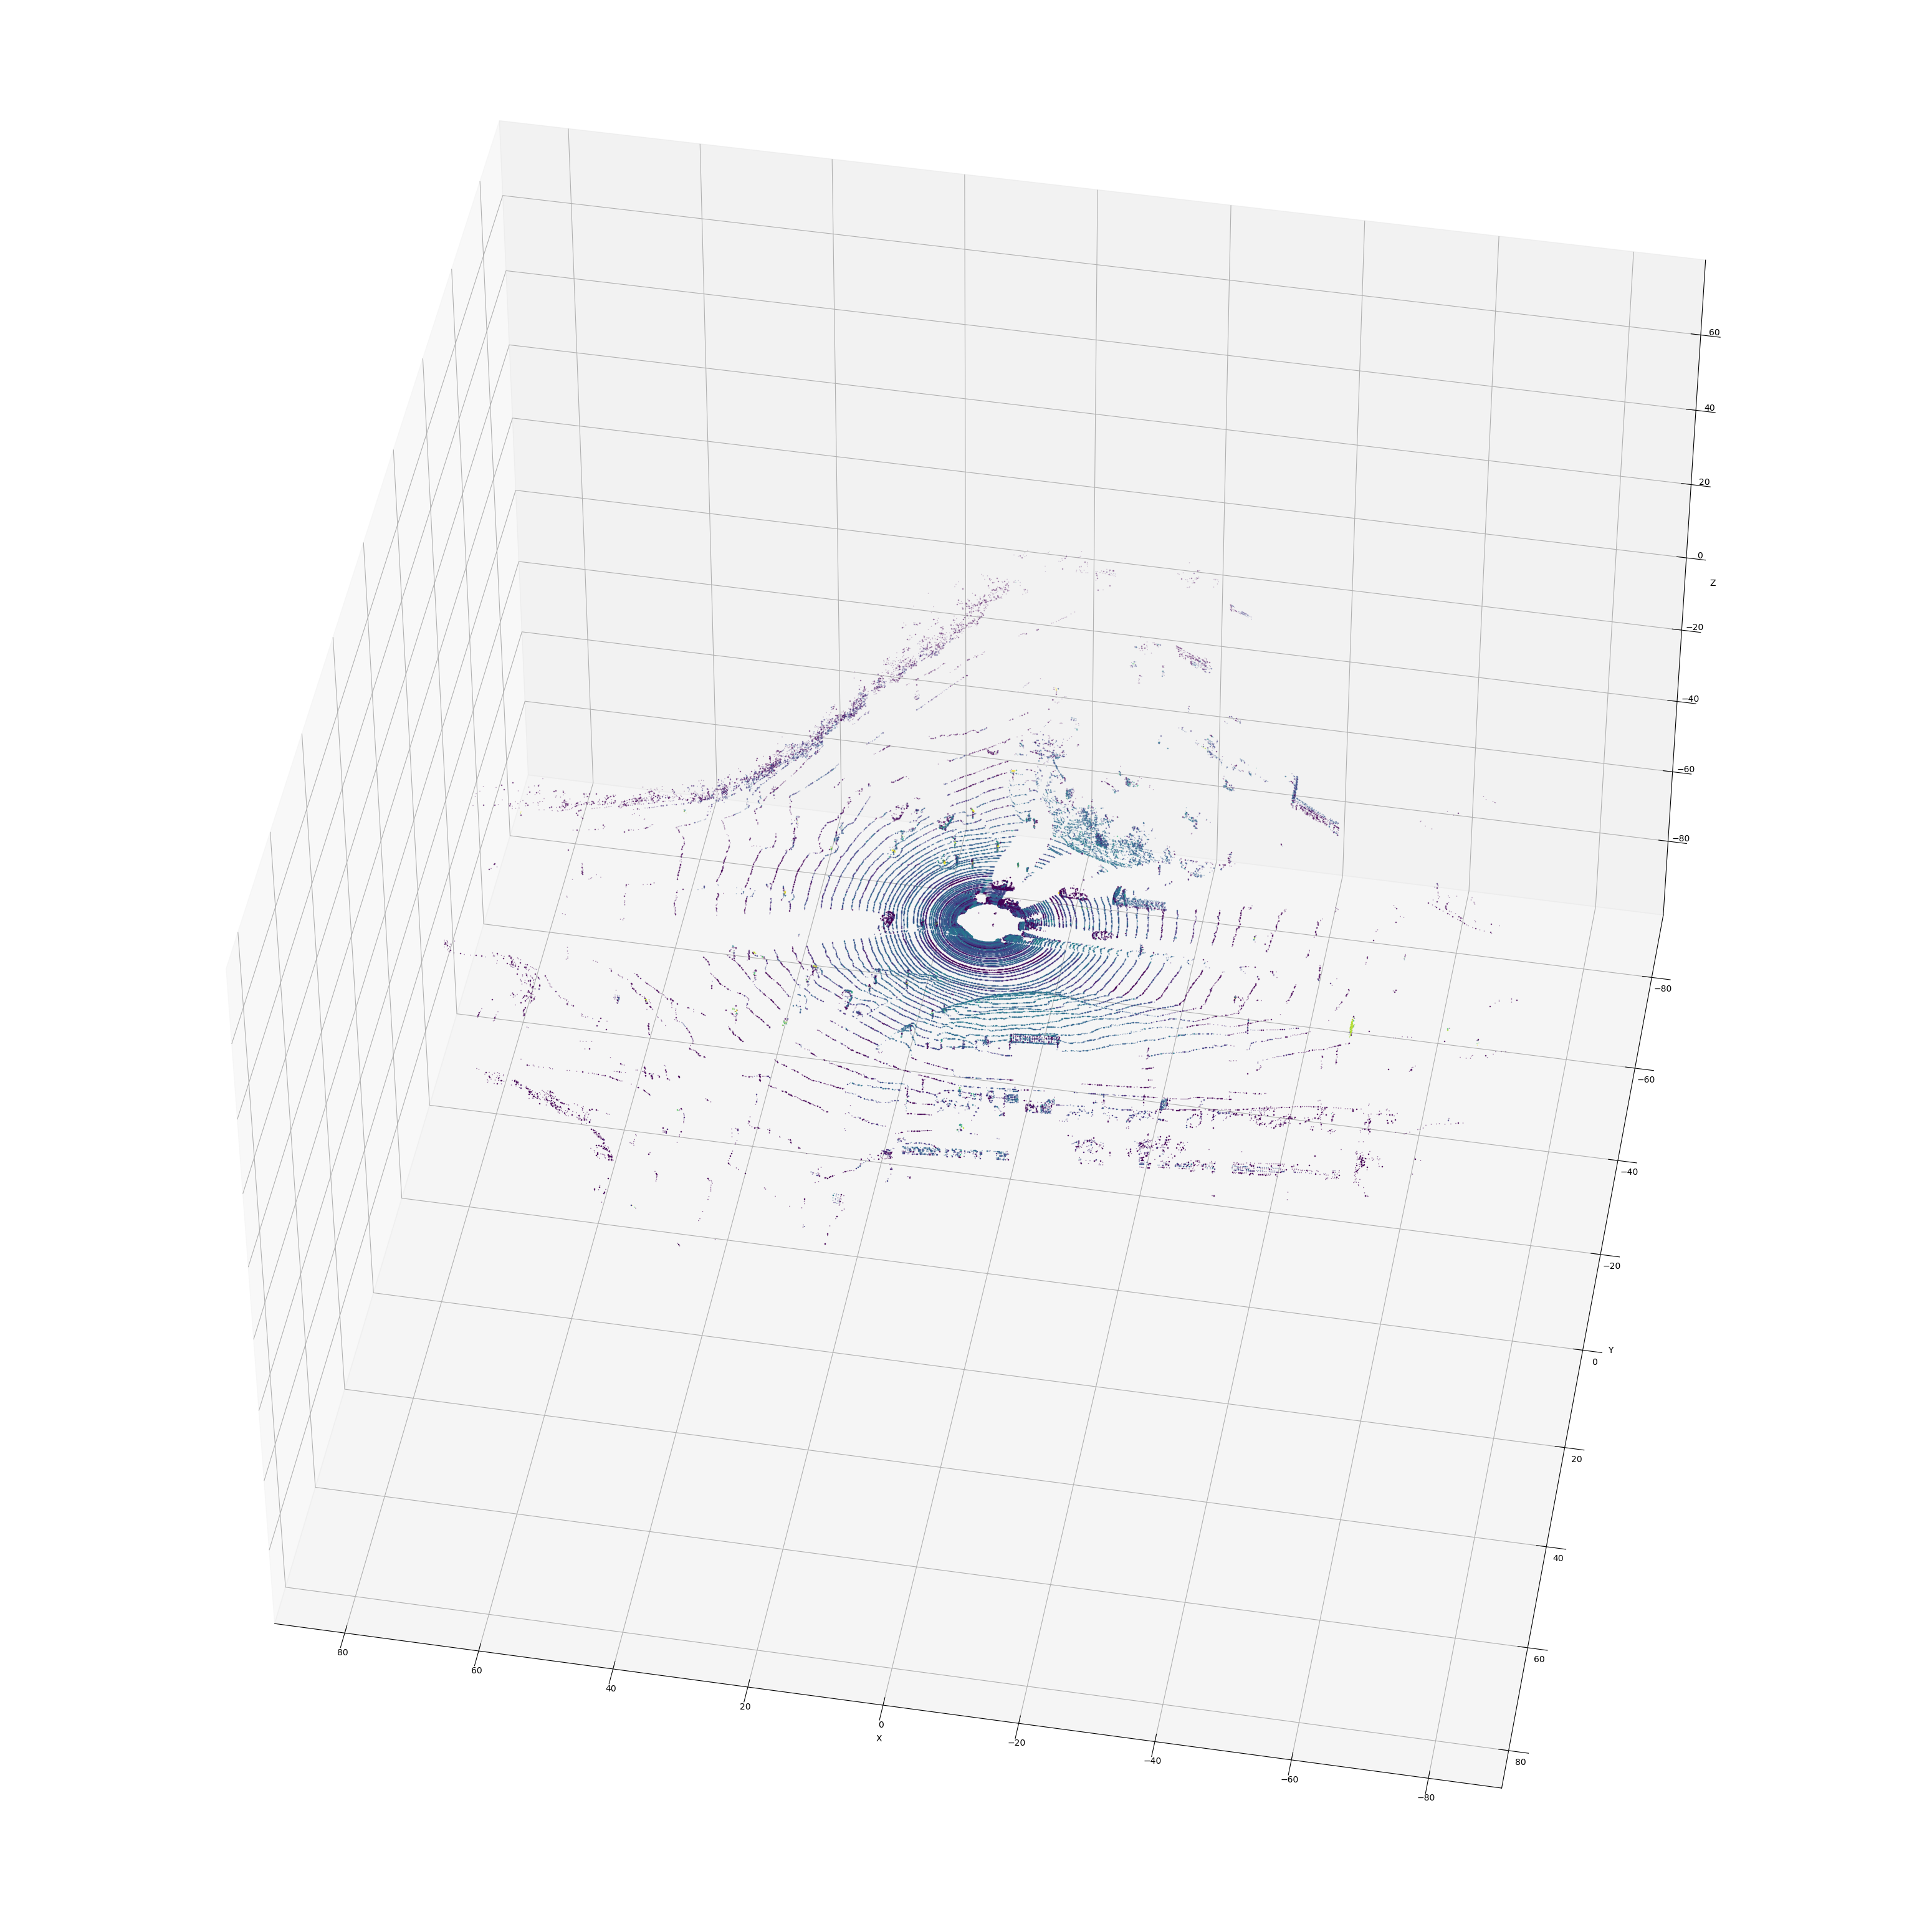

In [31]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(filtered_points[:, 0], filtered_points[:, 1], filtered_points[:, 2], s=0.1, c=filtered_points[:, 3], cmap='viridis', marker=',')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=45, azim=100) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()